# Validation and Final Evaluation of KeyBERT Extensions

In this notebook, we evaluate and compare the performance of the original KeyBERT model against two custom extensions:
- **KeyBERTSentimentReranker**: reranks keywords based on their sentiment alignment with the document.
- **KeyBERTSentimentAware**: integrates sentiment during keyword selection.

### Setup: Installing and Importing Required Libraries

In [62]:
import subprocess
import sys

# List of required packages
required_packages = [
    "numpy", "pandas", "torch", "scikit-learn", "matplotlib", "seaborn", "tqdm",
    "nltk", "scipy", "keybert", "transformers", "sentence-transformers"
]

def install_package(package):
    """Installs a package using pip if it's not already installed."""
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install missing packages
for package in required_packages:
    install_package(package)

numpy is already installed.
pandas is already installed.
torch is already installed.
Installing scikit-learn...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


matplotlib is already installed.
seaborn is already installed.
tqdm is already installed.
nltk is already installed.
scipy is already installed.
keybert is already installed.
transformers is already installed.
Installing sentence-transformers...
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [63]:
# Library for interacting with the operating system
import os

# Core libraries for data manipulation and analysis
import pandas as pd            
import numpy as np       

# Library for random number generation
import random

# Progress bar utility
from tqdm import tqdm         

# Visualization libraries
import matplotlib.pyplot as plt  
import seaborn as sns      

# Library for time-related functions
import time

# Similarity computation
from sklearn.metrics.pairwise import cosine_similarity  # Computes cosine similarity between vectors (e.g., between document and keyword embeddings)

# Loads pretrained BERT-based models to compute dense vector representations of text
from sentence_transformers import SentenceTransformer  # type: ignore

# Main library used for extracting keywords from documents using BERT embeddings
from keybert import KeyBERT  # type: ignore

# Library for displaying HTML content in Jupyter notebooks
from IPython.display import display

# Library for text formatting
from textwrap import fill


### Load Datasets

This cell loads the main datasets used in this project:

- `preprocessed_sw_reviews_df.pkl` and `preprocessed_others_reviews_df.pkl`:  
  These contain preprocessed reviews (lemmatized, stopword-removed, lower-cased, ...) for Star Wars and other movies.
  
- `custom_preprocessed_sw_reviews_df.pkl` and `custom_preprocessed_others_reviews_df.pkl`:  
  These are further processed versions where generic film-related terms (e.g., "movie", "director", "cinema") are removed to avoid bias in keyword extraction.

- `keywords_df.pkl`:  
  A manually annotated dataset containing keywords per movie along with their "Helpful" and "Not_Helpful" vote counts from users.

**Included movies:**

- **Star Wars Series:**
  - Star Wars: Episode I - The Phantom Menace (1999)
  - Star Wars: Episode II - Attack of the Clones (2002)
  - Star Wars: Episode III - Revenge of the Sith (2005)
  - Star Wars: Episode IV - A New Hope (1977)
  - Star Wars: Episode V - The Empire Strikes Back (1980)
  - Star Wars: Episode VI - Return of the Jedi (1983)
  - Star Wars: Episode VII - The Force Awakens (2015)
  - Star Wars: Episode VIII - The Last Jedi (2017)
  - Star Wars: Episode IX - The Rise of Skywalker (2019)

- **Other Movies:**
  - Parasite (2019)  
  - The Good, the Bad and the Ugly (1966)  
  - Harry Potter and the Sorcerer's Stone (2001)  
  - Oppenheimer (2023)  
  - La La Land (2016)  
  - Raiders of the Lost Ark (1981)

In [64]:
# Define paths
DATA_DIR = "../../Dataset"

# Preprocessed review datasets
PREPROCESSED_SW_PATH = os.path.join(DATA_DIR, "preprocessed_sw_reviews_df.pkl")
PREPROCESSED_OTHERS_PATH = os.path.join(DATA_DIR, "preprocessed_others_reviews_df.pkl")

# Custom review datasets (with film-related terms removed)
CUSTOM_SW_PATH = os.path.join(DATA_DIR, "custom_preprocessed_sw_reviews_df.pkl")
CUSTOM_OTHERS_PATH = os.path.join(DATA_DIR, "custom_preprocessed_others_reviews_df.pkl")

# Reference keyword annotations
KEYWORDS_PATH = os.path.join(DATA_DIR, "keywords_df.pkl")

# Load datasets
sw_df = pd.read_pickle(PREPROCESSED_SW_PATH)
others_df = pd.read_pickle(PREPROCESSED_OTHERS_PATH)
sw_custom_df = pd.read_pickle(CUSTOM_SW_PATH)
others_custom_df = pd.read_pickle(CUSTOM_OTHERS_PATH)
keywords_df = pd.read_pickle(KEYWORDS_PATH)

# Display basic info
print("Star Wars reviews (preprocessed):", sw_df.shape)
print("Other reviews (preprocessed):", others_df.shape)
print("Star Wars reviews (custom):", sw_custom_df.shape)
print("Other reviews (custom):", others_custom_df.shape)
print("Keywords annotation:", keywords_df.shape)

Star Wars reviews (preprocessed): (36192, 11)
Other reviews (preprocessed): (15132, 11)
Star Wars reviews (custom): (36192, 11)
Other reviews (custom): (15132, 11)
Keywords annotation: (5617, 4)


In [65]:
# Display function
def display_datasets(sw_df, others_df, sw_custom_df, others_custom_df, keywords_df):
    print("Star Wars Reviews (Preprocessed):")
    display(sw_df.head())

    print("\nOther Reviews (Preprocessed):")
    display(others_df.head())

    print("\nStar Wars Reviews (Custom):")
    display(sw_custom_df.head())

    print("\nOther Reviews (Custom):")
    display(others_custom_df.head())

    print("\nKeywords Annotation:")
    display(keywords_df.head())

# Display datasets
display_datasets(sw_df, others_df, sw_custom_df, others_custom_df, keywords_df)


Star Wars Reviews (Preprocessed):


,Review_ID,Movie_ID,Movie_Title,Rating,Review_Date,Review_Title,Review_Text,Helpful_Votes,Total_Votes,Processed_Review_Text,Processed_Review_Title
0,2221293,tt0076759,Star Wars: Episode IV - A New Hope,NaN,15 March 2010,Impossible to watch with fresh eyes,It was a long time ago when I first saw Star W...,0.0,0.0,long time ago first see star war watch part tr...,impossible watch fresh eye
1,4756672,tt0076759,Star Wars: Episode IV - A New Hope,10.0,1 April 2019,It's Still Just Star Wars to Me,While I will acknowledge its faults this is st...,0.0,0.0,acknowledge fault still one favorite film time...,still star war
2,0156096,tt0076759,Star Wars: Episode IV - A New Hope,10.0,19 January 1999,A modern myth that can't be beat,Star Wars is a modern myth that has a story li...,0.0,0.0,star war modern myth story line can not beat t...,modern myth can not beat
3,0155657,tt0076759,Star Wars: Episode IV - A New Hope,NaN,28 August 1999,There is a God and his name is George Lucas,I saw for the first time when I was six years ...,0.0,0.0,see first time six year old way back get old...,god name george lucas
4,0155649,tt0076759,Star Wars: Episode IV - A New Hope,1.0,31 August 1999,Good but over-rated.,"Frankly, I think ""Star wars"" is a great movie....",7.0,53.0,frankly think star war great movie way first...,good overrate



Other Reviews (Preprocessed):


,Review_ID,Movie_ID,Movie_Title,Rating,Review_Date,Review_Title,Review_Text,Helpful_Votes,Total_Votes,Processed_Review_Text,Processed_Review_Title
0,9637661,tt6751668,Parasite,5.0,23 February 2024,"Solid Film Craftsmanship, Trash Story",I'm genuinely baffled this film won not only b...,3.0,8.0,genuinely baffle film good foreign film good d...,solid film craftsmanship trash story
1,5510542,tt6751668,Parasite,10.0,26 February 2020,MASTERPIECE,Just watch it. It has everything; entertainmen...,3.0,5.0,watch everything entertainment comedy thrill h...,masterpiece
2,5182892,tt6751668,Parasite,10.0,12 October 2019,First Hit: I really enjoyed this story as it d...,First Hit: I really enjoyed this story as it d...,24.0,40.0,first hit really enjoy story dive hilarious ab...,first hit really enjoy story dive hilarious ab...
3,5499682,tt6751668,Parasite,9.0,21 February 2020,If you love cliché stories this movie is not f...,I was not expecting that much of this movie. N...,2.0,5.0,expect much movie normally film nominate oscar...,love clich story movie
4,6094155,tt6751668,Parasite,8.0,14 September 2020,Amazing.,"Good acting, cinematography, twists and screen...",0.0,0.0,good act cinematography twist screenplay side ...,amazing



Star Wars Reviews (Custom):


,Review_ID,Movie_ID,Movie_Title,Rating,Review_Date,Review_Title,Review_Text,Helpful_Votes,Total_Votes,Processed_Review_Text,Processed_Review_Title
0,2221293,tt0076759,Star Wars: Episode IV - A New Hope,NaN,15 March 2010,Impossible to watch with fresh eyes,It was a long time ago when I first saw Star W...,0.0,0.0,long time ago first see star war watch part ea...,impossible watch fresh eye
1,4756672,tt0076759,Star Wars: Episode IV - A New Hope,10.0,1 April 2019,It's Still Just Star Wars to Me,While I will acknowledge its faults this is st...,0.0,0.0,acknowledge fault still one favorite time reme...,still star war
2,0156096,tt0076759,Star Wars: Episode IV - A New Hope,10.0,19 January 1999,A modern myth that can't be beat,Star Wars is a modern myth that has a story li...,0.0,0.0,star war modern myth story line can not beat t...,modern myth can not beat
3,0155657,tt0076759,Star Wars: Episode IV - A New Hope,NaN,28 August 1999,There is a God and his name is George Lucas,I saw for the first time when I was six years ...,0.0,0.0,see first time six year old way back get old t...,god name george lucas
4,0155649,tt0076759,Star Wars: Episode IV - A New Hope,1.0,31 August 1999,Good but over-rated.,"Frankly, I think ""Star wars"" is a great movie....",7.0,53.0,frankly think star war great way first kind im...,good overrate



Other Reviews (Custom):


,Review_ID,Movie_ID,Movie_Title,Rating,Review_Date,Review_Title,Review_Text,Helpful_Votes,Total_Votes,Processed_Review_Text,Processed_Review_Title
0,9637661,tt6751668,Parasite,5.0,23 February 2024,"Solid Film Craftsmanship, Trash Story",I'm genuinely baffled this film won not only b...,3.0,8.0,genuinely baffle good foreign good directing w...,solid film craftsmanship trash story
1,5510542,tt6751668,Parasite,10.0,26 February 2020,MASTERPIECE,Just watch it. It has everything; entertainmen...,3.0,5.0,watch everything entertainment comedy thrill h...,masterpiece
2,5182892,tt6751668,Parasite,10.0,12 October 2019,First Hit: I really enjoyed this story as it d...,First Hit: I really enjoyed this story as it d...,24.0,40.0,first hit really enjoy story dive hilarious ab...,first hit really enjoy story dive hilarious ab...
3,5499682,tt6751668,Parasite,9.0,21 February 2020,If you love cliché stories this movie is not f...,I was not expecting that much of this movie. N...,2.0,5.0,expect much normally nominate oscar favorite s...,love clich story movie
4,6094155,tt6751668,Parasite,8.0,14 September 2020,Amazing.,"Good acting, cinematography, twists and screen...",0.0,0.0,good act twist screenplay side like location c...,amazing



Keywords Annotation:


,Movie_ID,Keyword,Helpful,Not_Helpful
0,tt0076759,rebellion,15,0
1,tt0076759,princess,12,0
2,tt0076759,space opera,11,0
3,tt0076759,good versus evil,10,0
4,tt0076759,droid,9,0


### Load Custom KeyBERT Extensions

In this step, we import the custom KeyBERT extensions developed specifically for this project:

- `KeyBERTSentimentReranker`: re-ranks the keywords extracted by standard KeyBERT based on their sentiment alignment with the overall tone of the document.
- `KeyBERTSentimentAware`: integrates sentiment directly into the keyword selection phase, adjusting the similarity score using a transformer-based sentiment classifier.

These models are used alongside the original KeyBERT to assess the impact of incorporating sentiment information into keyword extraction.

**Note:**

>  All models share the same embedding backbone (`all-MiniLM-L6-v2`) to ensure a fair and consistent comparison.  

> The sentiment-aware variants use a transformer-based sentiment classifier, with `cardiffnlp/twitter-roberta-base-sentiment` as the default option (alternatively, `nlptown/bert-base-multilingual-uncased-sentiment` can be used).  

> An alpha value of **0.5** is used uniformly across both extensions to balance semantic similarity and sentiment influence.


In [66]:
# Add custom module path
import sys
sys.path.append("../../SentimentAwareKeyBERT") 

# Import custom KeyBERT extensions
from models.reranker_sentiment import KeyBERTSentimentReranker  # Post-hoc sentiment-based reranking
from models.embedding_sentiment import KeyBERTSentimentAware    # Sentiment-aware selection during extraction

# Import base model and sentence transformer
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer

# Instantiate the models with the same embedding backbone
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

model_base = KeyBERT(
                model=embedding_model, 
                )

model_reranker = KeyBERTSentimentReranker(
    model=embedding_model,
    alpha=0.5,  # Weight for the sentiment score in the reranking process
    sentiment_model_name="cardiffnlp/twitter-roberta-base-sentiment"  # You can also use: "nlptown/bert-base-multilingual-uncased-sentiment"
)

model_sentiment_aware = KeyBERTSentimentAware(
    model=embedding_model,
    alpha=0.5,  # Weight for the sentiment score in the extraction process
    sentiment_model_name="cardiffnlp/twitter-roberta-base-sentiment"  # You can also use: "nlptown/bert-base-multilingual-uncased-sentiment"
)

print("All models loaded successfully.")


All models loaded successfully.


## Validation 1 - Semantic Level

In [67]:
# Function to explore the keywords DataFrame
def explore_keywords_df(df):
    film_counts = df.groupby("Movie_ID")["Keyword"].count().sort_values(ascending=False)
    print("Available films and keyword counts:")
    print(film_counts)  # mostra i primi 10 film con più keyword
    return film_counts

# Explore the keywords DataFrame
film_counts = explore_keywords_df(keywords_df)

Available films and keyword counts:
Movie_ID
tt2527338     598
tt2527336     546
tt2488496     515
tt0121766     477
tt0120915     410
tt0241527     400
tt0121765     386
tt0076759     347
tt15398776    325
tt6751668     316
tt0080684     291
tt3783958     290
tt0060196     273
tt0086190     223
tt0082971     220
Name: Keyword, dtype: int64


In [68]:
# Select specific film
selected_film_id = "tt0082971"  # Movie_ID for "Raiders of the Lost Ark"

film_df = others_custom_df[others_custom_df["Movie_ID"] == selected_film_id]
film_df.head(5)

,Review_ID,Movie_ID,Movie_Title,Rating,Review_Date,Review_Title,Review_Text,Helpful_Votes,Total_Votes,Processed_Review_Text,Processed_Review_Title
0,0188765,tt0082971,Raiders of the Lost Ark,NaN,2 July 1999,Best opening sequence ever...,I remember the opening 10 minutes of this film...,1.0,2.0,remember opening minute one good moment everyt...,good opening sequence ever
1,3070630,tt0082971,Raiders of the Lost Ark,10.0,17 August 2014,Timeless adventure classic,There are no set qualities for a great film. S...,8.0,12.0,set quality great like citizen kane tower cath...,timeless adventure classic
2,0188569,tt0082971,Raiders of the Lost Ark,10.0,3 August 1998,Best of the Best,My favorite movie of all time.. the original a...,5.0,8.0,favorite time original actionadventure blockbu...,good good
3,5237029,tt0082971,Raiders of the Lost Ark,10.0,5 November 2019,The Birth of a Myth by Filmmaking Legends,"Imagined by George Lucas and Philip Kaufman, w...",2.0,2.0,imagine george lucas philip kaufman write lawr...,birth myth filmmake legend
4,5664690,tt0082971,Raiders of the Lost Ark,8.0,22 April 2020,The story of Dr. Jones looking for the Ark,Dr. Jones has a well-known name in the archaeo...,2.0,3.0,dr jones wellknown name archaeological world a...,story dr jones look ark


In [73]:
from tqdm import tqdm

def extract_keywords_from_reviews(reviews, model, top_k=5):
    # Initialize a list to store all keywords from all reviews
    all_keywords = []

    # Loop over each review text with progress bar
    for text in tqdm(reviews, desc="Extracting keywords", total=len(reviews)):

        # Extract top_k keywords from the current review using the specified model
        keywords = model.extract_keywords(text, top_n=top_k)

        # Add only the keyword strings (not their scores) to the list
        all_keywords.extend([kw[0] for kw in keywords])

    # Return the full list of extracted keywords across all reviews
    return all_keywords

In [70]:
from collections import Counter

def select_top_keywords(candidate_keywords, all_reviews, top_n=220, bert_model=None):
    
    # Count keyword frequencies across all reviews
    freq_counter = Counter(candidate_keywords)

    # Select the top 3*top_n most common keywords as initial candidates
    most_common = [kw for kw, _ in freq_counter.most_common(3 * top_n)]

    # Compute the embedding of the entire set of reviews (joined into one document)
    doc_embedding = bert_model.encode([" ".join(all_reviews)], convert_to_tensor=True)

    # Compute embeddings for the most common candidate keywords
    keyword_embeddings = bert_model.encode(most_common, convert_to_tensor=True)

    # Calculate cosine similarity between the document embedding and each keyword
    sims = cosine_similarity(
            doc_embedding.cpu().numpy(),
            keyword_embeddings.cpu().numpy()
        )[0]


    # Normalize keyword frequency scores to [0, 1]
    freq_scores = np.array([freq_counter[kw] for kw in most_common], dtype=np.float32)
    freq_scores /= freq_scores.max()

    # Combine frequency and similarity scores equally
    final_scores = 0.5 * sims + 0.5 * freq_scores

    # Select indices of the top_n highest scoring keywords
    top_indices = np.argsort(final_scores)[-top_n:]

    # Retrieve the corresponding keywords
    selected_keywords = [most_common[i] for i in top_indices]

    return selected_keywords

In [71]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def semantic_overlap_score(generated_keywords, true_keywords, true_helpfulness=None, model_name="", top_k=5, bert_model=None):
    
    # Encode generated and true keywords into embeddings using the given BERT model
    emb_generated = bert_model.encode(generated_keywords, convert_to_tensor=True)
    emb_true = bert_model.encode(true_keywords, convert_to_tensor=True)

    # Compute cosine similarity between each generated keyword and all true keywords
    sim_matrix = cosine_similarity(
            emb_generated.cpu().numpy(),
            emb_true.cpu().numpy()
    )


    # If helpfulness is provided, assign higher weights to "Helpful" keywords
    if true_helpfulness is not None:
        weights = np.array([1.0 if h == "Helpful" else 0.5 for h in true_helpfulness])
    else:
        weights = np.ones(len(true_keywords))  # default: equal weight

    match_scores = []

    # For each generated keyword's similarity vector
    for sim_vector in sim_matrix:
        # Get indices of top_k most similar true keywords
        top_indices = np.argsort(sim_vector)[-top_k:]

        # Compute a weighted average of those similarities
        weighted_score = np.mean(sim_vector[top_indices] * weights[top_indices])
        match_scores.append(weighted_score)

    # Final score: average over all generated keywords
    final_score = np.mean(match_scores)

    # Print model name and final score
    print(f"{model_name} → Weighted semantic similarity: {final_score:.4f}")
    
    return final_score


In [74]:
from sentence_transformers import SentenceTransformer

def evaluate_all_models(film_df, keywords_df, film_id, models_dict, top_k_per_review=5):
    # Extract the list of processed reviews for the selected film
    processed_reviews = film_df["Processed_Review_Text"].tolist()

    # Retrieve the ground truth keywords and their helpfulness labels for this film
    true_keywords_df = keywords_df[keywords_df["Movie_ID"] == film_id]
    true_keywords = true_keywords_df["Keyword"].tolist()
    true_helpfulness = true_keywords_df["Helpful"].tolist()
    n_keywords = len(true_keywords)  # number of keywords to generate for comparison

    # Load the sentence transformer model used for embeddings
    bert_model = SentenceTransformer("all-MiniLM-L6-v2")

    # Dictionary to store results for each model
    results = {}

    # Loop through each keyword extraction model
    #for model_name, model_instance in tqdm(models_dict.items(), desc="Evaluating models"):
    for model_name, model_instance in models_dict.items():
        print(f"\nEvaluating model: {model_name}")

        # Step 1: Extract keywords from each review using the current model
        all_candidates = extract_keywords_from_reviews(
            processed_reviews,
            model_instance,
            top_k=top_k_per_review
        )

        # Step 2: Select top representative keywords based on frequency + semantic centrality
        final_keywords = select_top_keywords(
            candidate_keywords=all_candidates,
            all_reviews=processed_reviews,
            top_n=n_keywords,
            bert_model=bert_model
        )

        # Step 3: Evaluate similarity against true keywords (weighted by helpfulness)
        score = semantic_overlap_score(
            generated_keywords=final_keywords,
            true_keywords=true_keywords,
            true_helpfulness=true_helpfulness,
            model_name=model_name,
            top_k=5,
            bert_model=bert_model
        )

        # Store the results
        results[model_name] = {
            "keywords": final_keywords,
            "score": score
        }

    return results


In [75]:
# Define dictionary with all your initialized models
models_dict = {
    "KeyBERT": model_base,
    "KeyBERTReranker": model_reranker,
    "KeyBERTSentimentAware": model_sentiment_aware,
}

# Evaluate all models on the selected film
results = evaluate_all_models(
    film_df=film_df.sample(50, random_state=42),
    keywords_df=keywords_df,
    film_id="tt0082971",
    models_dict=models_dict,
    top_k_per_review=5  # number of keywords extracted per review
)



Evaluating model: KeyBERT


Extracting keywords: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


KeyBERT → Weighted semantic similarity: 0.2234

Evaluating model: KeyBERTReranker


Extracting keywords: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


KeyBERTReranker → Weighted semantic similarity: 0.2234

Evaluating model: KeyBERTSentimentAware


Extracting keywords: 100%|██████████| 50/50 [08:39<00:00, 10.39s/it]


KeyBERTSentimentAware → Weighted semantic similarity: 0.1889


## Validation 2 - Sentiment Level

# RICORDATI DI FARE UN DATASET SENZA LOWERCASE MA CON UPPERCASE PERCHE' PUO' SERVIRE

In [6]:
# Select specific film
selected_film = "Star Wars: Episode VI - Return of the Jedi"
film_df = sw_custom_df[sw_custom_df["Movie_Title"] == selected_film]

# Separate reviews with and without rating
with_rating_df = film_df[film_df["Rating"].notnull()]
without_rating_df = film_df[film_df["Rating"].isnull()]

# Summary
print(f"Total reviews for '{selected_film}': {len(film_df)}")
print(f"- Reviews with rating: {len(with_rating_df)}")
print(f"- Reviews without rating: {len(without_rating_df)}")

Total reviews for 'Star Wars: Episode VI - Return of the Jedi': 1017
- Reviews with rating: 912
- Reviews without rating: 105


In [7]:
# Map numerical rating (1–10) to 5 sentiment classes
def rating_to_label(rating):
    if rating <= 3.5:
        return "Very Negative"
    elif rating < 5.5:
        return "Negative"
    elif rating <= 6.5:
        return "Neutral"
    elif rating < 8.5:
        return "Positive"
    else:
        return "Very Positive"

# Map average sentiment score (0–1) to the same 5 sentiment classes
def sentiment_to_label(sentiment):
    if sentiment <= 0.35:
        return "Very Negative"
    elif sentiment < 0.55:
        return "Negative"
    elif sentiment <= 0.65:
        return "Neutral"
    elif sentiment < 0.85:
        return "Positive"
    else:
        return "Very Positive"


In [8]:
# Function to weight the sentiment score based on the position of the keyword in the ranked list
def compute_weighted_sentiment(keywords_with_sentiment, weights=None):
    """
    Compute a weighted average sentiment score for a list of (keyword, score, polarity) tuples.
    
    Parameters:
    - keywords_with_sentiment: List of (kw, score, polarity) tuples.
    - weights: Optional list of weights for the positions. If None, default weights are used.
    
    Returns:
    - weighted_sentiment: Float value ∈ [0, 1]
    """
    sentiments = [pol for _, _, pol in keywords_with_sentiment]
    
    if weights is None:
        k = len(sentiments)
        weights = 1 / np.log2(np.arange(2, k + 2))  # DCG-style weights
        weights /= weights.sum()  # Normalize to sum = 1
    
    weighted_sentiment = np.dot(weights, sentiments)
    return float(weighted_sentiment)


In [25]:
from tqdm import tqdm

def validate_models_on_reviews(
        reviews_df, models_dict, 
        sentiment_model, 
        top_n=5, 
        text_col="Processed_Review_Text", 
        rating_col = "Rating",):
    """
    For each review, extract keywords from each model, compute weighted sentiment, and compare to rating label.
    Uses model_name checks to handle format differences explicitly.
    
    Parameters:
    - reviews_df: DataFrame containing reviews and ratings
    - text_col: name of column containing the cleaned review text
    - rating_col: name of column containing the numeric rating
    - models_dict: dictionary of {model_name: model_instance}
    - sentiment_model: SentimentModel instance (used only for KeyBERT)
    - top_n: number of keywords to extract

    Returns:
    - DataFrame with one row per (review, model) pair containing predicted and true labels.
    """
    rows = []

    for _, row in tqdm(reviews_df.iterrows(), total=len(reviews_df), desc="Processing reviews"):
        review_text = row[text_col]
        rating = row[rating_col]
        true_label = rating_to_label(rating)

        for model_name, model in models_dict.items():
            try:
                keywords = model.extract_keywords(review_text, top_n=top_n, keyphrase_ngram_range=(1, 3))

                # Handle each model type
                if model_name == "KeyBERT":
                    # No sentiment → apply SentimentModel externally
                    # Compute (kw, score, polarity) tuples manually
                    keywords_with_sentiment = []
                    for kw, score in keywords:
                        probs = sentiment_model.predict_proba(kw)[0]  # get array for that kw
                        polarity = sum(
                            p * sentiment_model.label_to_score[label]
                            for p, label in zip(probs, sentiment_model.labels_ordered)
                        )
                        keywords_with_sentiment.append((kw, score, polarity))

                    keywords = keywords_with_sentiment

                # Compute weighted sentiment and predicted label
                weighted_sent = compute_weighted_sentiment(keywords)
                pred_label = sentiment_to_label(weighted_sent)

                rows.append({
                    "Review_Text": review_text,
                    "Rating": rating,
                    "True_Label": true_label,
                    "Model": model_name,
                    "Pred_Label": pred_label,
                    "Weighted_Sentiment": weighted_sent
                })

            except Exception as e:
                print(f"Error on model '{model_name}' - {e}")

    return pd.DataFrame(rows)


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Map sentiment labels to integers for distance computation
label_order = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
label_to_int = {label: i for i, label in enumerate(label_order)}

def compute_distance_error(y_true, y_pred):
    """
    Computes the average ordinal distance between predicted and true labels.
    """
    true_vals = np.array([label_to_int[label] for label in y_true])
    pred_vals = np.array([label_to_int[label] for label in y_pred])
    return np.mean(np.abs(true_vals - pred_vals))

def evaluate_validation_results(df, true_col="True_Label", pred_col="Pred_Label", model_col="Model"):
    """
    Print evaluation metrics and plot confusion matrix per model.

    Parameters:
    - df: DataFrame with true and predicted labels per model
    - true_col: column with ground truth labels
    - pred_col: column with predicted labels
    - model_col: column with model names
    """
    models = df[model_col].unique()

    for model in models:
        print(f"\nEvaluation for model: {model}")
        subset = df[df[model_col] == model]

        y_true = subset[true_col]
        y_pred = subset[pred_col]

        acc = accuracy_score(y_true, y_pred)
        f1_macro = f1_score(y_true, y_pred, average="macro")
        f1_weighted = f1_score(y_true, y_pred, average="weighted")
        dist_error = compute_distance_error(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=label_order)

        print("Accuracy:", acc)
        print("F1-score (macro):", f1_macro)
        print("F1-score (weighted):", f1_weighted)
        print("Distance-based Error (ordinal):", dist_error)
        print("\nClassification Report:\n")
        print(classification_report(y_true, y_pred, labels=label_order))

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_order, yticklabels=label_order)
        plt.title(f"Confusion Matrix for {model}")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.tight_layout()
        plt.show()


In [ ]:
# Initialize the sentiment model
import sys
sys.path.append("../../SentimentAwareKeyBERT") 

from models.sentiment_model import SentimentModel  # Custom sentiment model class

sentiment_model = SentimentModel("cardiffnlp/twitter-roberta-base-sentiment")

# Testing with 3 models (initializad at the beginning):
models = {
    "KeyBERT": model_base,
    "Reranker": model_reranker,
    "SentimentAware": model_sentiment_aware
}

# Instantiate the sentiment model
sentiment_model = SentimentModel("cardiffnlp/twitter-roberta-base-sentiment")

# Execute the validation function
validation_df = validate_models_on_reviews(
    reviews_df=with_rating_df.sample(50, random_state=42), # Sample 50 reviews for validation
    models_dict=models,
    sentiment_model=sentiment_model,
    top_n=5,
    text_col="Processed_Review_Text",
    rating_col="Rating"
)


Processing reviews: 100%|██████████| 50/50 [15:54<00:00, 19.10s/it]



Evaluation for model: KeyBERT
Accuracy: 0.06
F1-score (macro): 0.022641509433962266
F1-score (weighted): 0.00679245283018868
Distance-based Error (ordinal): 2.2

Classification Report:

               precision    recall  f1-score   support

Very Negative       0.00      0.00      0.00         2
     Negative       0.06      1.00      0.11         3
      Neutral       0.00      0.00      0.00         2
     Positive       0.00      0.00      0.00        23
Very Positive       0.00      0.00      0.00        20

     accuracy                           0.06        50
    macro avg       0.01      0.20      0.02        50
 weighted avg       0.00      0.06      0.01        50



/Users/manuelemustari/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manuelemustari/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manuelemustari/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

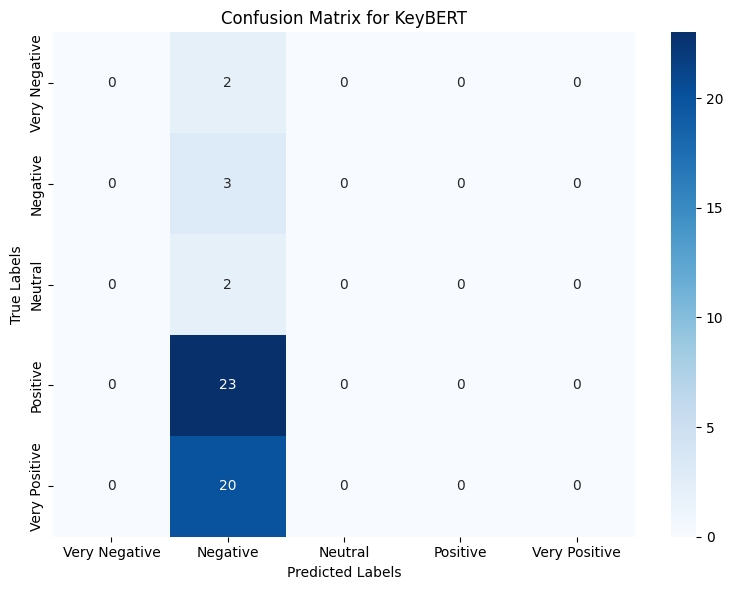


Evaluation for model: Reranker
Accuracy: 0.14
F1-score (macro): 0.09590017825311944
F1-score (weighted): 0.16117647058823528
Distance-based Error (ordinal): 1.62

Classification Report:

               precision    recall  f1-score   support

Very Negative       0.00      0.00      0.00         2
     Negative       0.07      0.67      0.12         3
      Neutral       0.00      0.00      0.00         2
     Positive       0.27      0.13      0.18        23
Very Positive       1.00      0.10      0.18        20

     accuracy                           0.14        50
    macro avg       0.27      0.18      0.10        50
 weighted avg       0.53      0.14      0.16        50



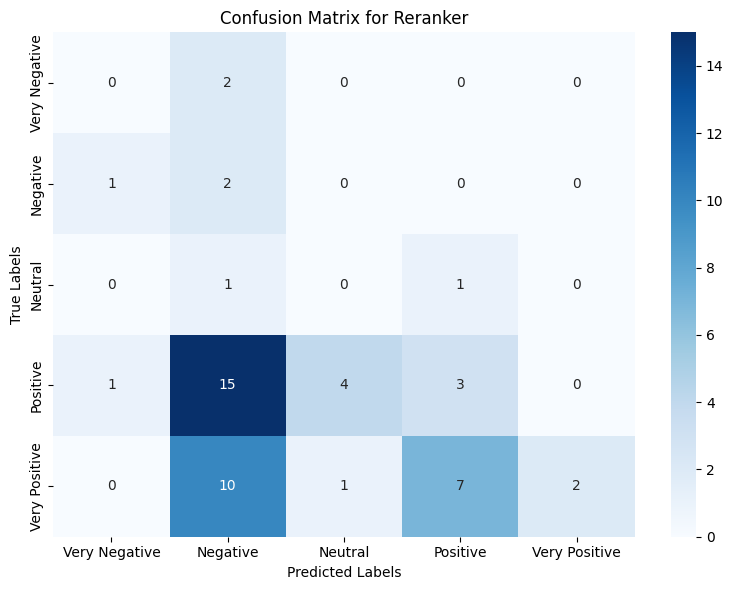


Evaluation for model: SentimentAware
Accuracy: 0.34
F1-score (macro): 0.25864661654135335
F1-score (weighted): 0.38205513784461154
Distance-based Error (ordinal): 1.22

Classification Report:

               precision    recall  f1-score   support

Very Negative       0.25      0.50      0.33         2
     Negative       0.06      0.33      0.10         3
      Neutral       0.00      0.00      0.00         2
     Positive       0.80      0.17      0.29        23
Very Positive       0.61      0.55      0.58        20

     accuracy                           0.34        50
    macro avg       0.34      0.31      0.26        50
 weighted avg       0.63      0.34      0.38        50



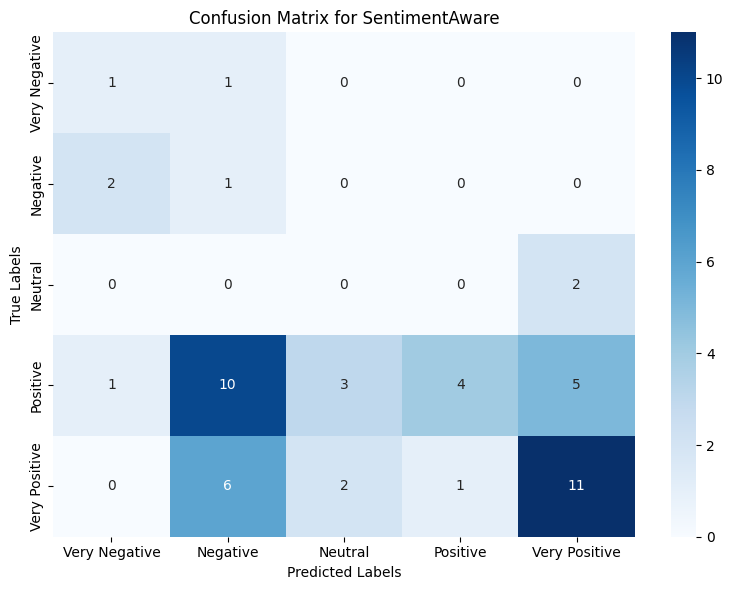

In [34]:
# Evaluate the results
evaluate_validation_results(validation_df, true_col="True_Label", pred_col="Pred_Label", model_col="Model")

In [32]:
validation_df

,Review_Text,Rating,True_Label,Model,Pred_Label,Weighted_Sentiment
0,possible unlikely spoilerwell sequel start wel...,7.0,Positive,KeyBERT,Negative,0.492723
1,possible unlikely spoilerwell sequel start wel...,7.0,Positive,Reranker,Negative,0.473187
2,possible unlikely spoilerwell sequel start wel...,7.0,Positive,SentimentAware,Negative,0.544261
3,pretty big fan star war like except one second...,6.0,Neutral,KeyBERT,Negative,0.495399
4,pretty big fan star war like except one second...,6.0,Neutral,Reranker,Negative,0.483421
...,...,...,...,...,...,...
145,incredible ending story original return jedi t...,9.0,Very Positive,Reranker,Positive,0.799392
146,incredible ending story original return jedi t...,9.0,Very Positive,SentimentAware,Very Positive,0.914083
147,star war vi return jedi fantastic ending terri...,8.0,Positive,KeyBERT,Negative,0.497849
148,star war vi return jedi fantastic ending terri...,8.0,Positive,Reranker,Neutral,0.564173


In [ ]:
import os

# Create the folder if it doesn't exist
results_dir = "../../SentimentAwareKeyBERT/results"
os.makedirs(results_dir, exist_ok=True)

selected_film = "StarWarsEpisodeVI"
filename = f"validation_{selected_film}.pkl"
filepath = os.path.join(results_dir, filename)

# Check if the file already exists
if os.path.exists(filepath):
    raise FileExistsError(f"File already exists: {filepath}\nPlease delete it manually before saving a new version.")

# Save the validation results
validation_df.to_pickle(filepath)
print(f"Saved validation results to: {filepath}")
